In [1]:
import numpy as np
import pandas as pd
import requests
import matplotlib.pylab as plt
%pylab inline

from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist, pdist
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

Populating the interactive namespace from numpy and matplotlib


/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# TIME SERIES ANALYSIS

# Goal: Find outliers, trends and periodicity in the MTA turnstile data
    

## DATA:
MTA subway fares. It is a complete dataset of
rides logged by card swipes for 600 Manhattan stations.


The data was organized  by Dr. Sina Kashuk at CUSP.
You can get it from the github repo (use the download link to download it live in your notebook). 
It contains 23 different subway card types 
(e.g. monthly pass, daily pass, Act for Disability pass…) as follows:


![ridetype](https://raw.githubusercontent.com/fedhere/PUI2017_fb55/master/HW10_fb55/Ridetypes.png)

## Each time series (per station, per ticket type) contains the number of swipes per week for 194 weeks from 05/21/2010 to 02/21/2014. 

The data are available to you as a *python data cube*. you can load it as 

```
np.load(“MTA_Fare.npy")
```

and you will end up with a python numpy array of 
shape (600, 23, 194)




In [2]:
# must download first!
# url = "https://github.com/fedhere/PUI2017_fb55/blob/master/HW10_fb55/MTA_Fare.npy?raw=true"

# load data
data = np.load('MTA_Fare.npy')

In [3]:
# check shape
data.shape

(600, 23, 194)

In [4]:
# change into float
data = data.astype('float')
# change into NaN
data[data == -1] = np.nan

In [5]:
datarange = pd.date_range('21/05/2010', periods=194, freq='W')

## Task 1: 
### Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.
### Identify it, figure out the date (you know when the data starts and what the cadence is) and figure out what it is due to.

In [6]:
# change into data shape to be (600*23, 194 week)
eachweek = data.reshape(600*23, 194)

In [7]:
print(eachweek.shape)

(13800, 194)


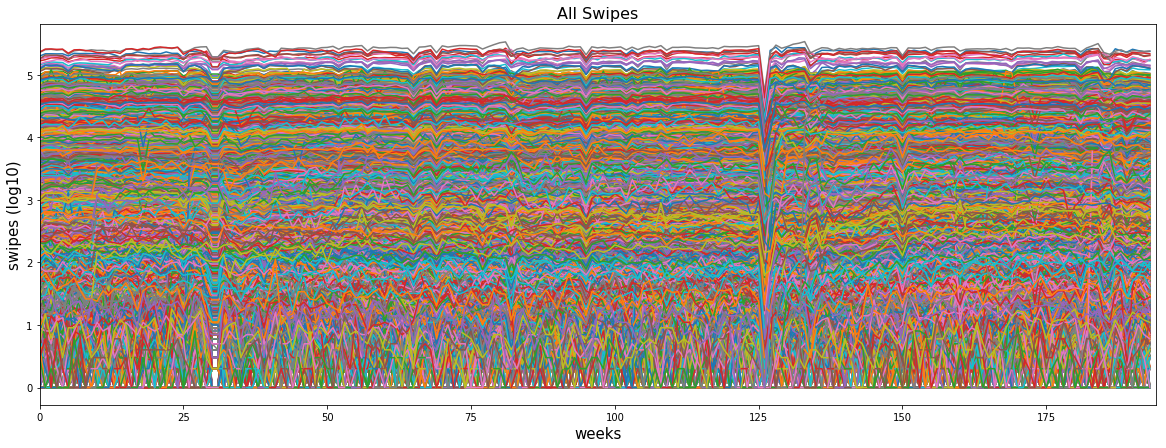

In [8]:
# plot the each swipe per each station per each week
plt.figure(figsize=(20,7))
plt.plot(np.log10(eachweek).T)
plt.title("All Swipes", fontsize=16)
plt.xlabel("weeks", fontsize=15)
plt.ylabel("swipes (log10)", fontsize=15)
plt.xlim(0, 194)
plt.show()

**Figure 1.** Messy data of all swipes per each station. There is a downhill after week 125.

In [9]:
#as described in the instruction for some of the analysis 
#one can sum time series for all stations
print (data.shape)
mtasumstation = np.nansum(data, axis=1)
print (mtasumstation.shape)
#or for all ride types
mtasumride = np.nansum(data, axis=0)
print (mtasumride.shape)

(600, 23, 194)
(600, 194)
(23, 194)


In [10]:
mtasumstation = np.nansum(data, axis=1)
mtaweek = np.nansum(mtasumstation, axis=0)
print(mtaweek.shape)

(194,)


In [11]:
# creating dataframe based on week
allswipe = pd.DataFrame({'Frequency' : mtaweek.T}, index = datarange)
allswipe.head()

,Frequency
2010-05-23,26720267.0
2010-05-30,29265971.0
2010-06-06,29601189.0
2010-06-13,29387592.0
2010-06-20,29185768.0


Text(0,0.5,'Swipe counts')

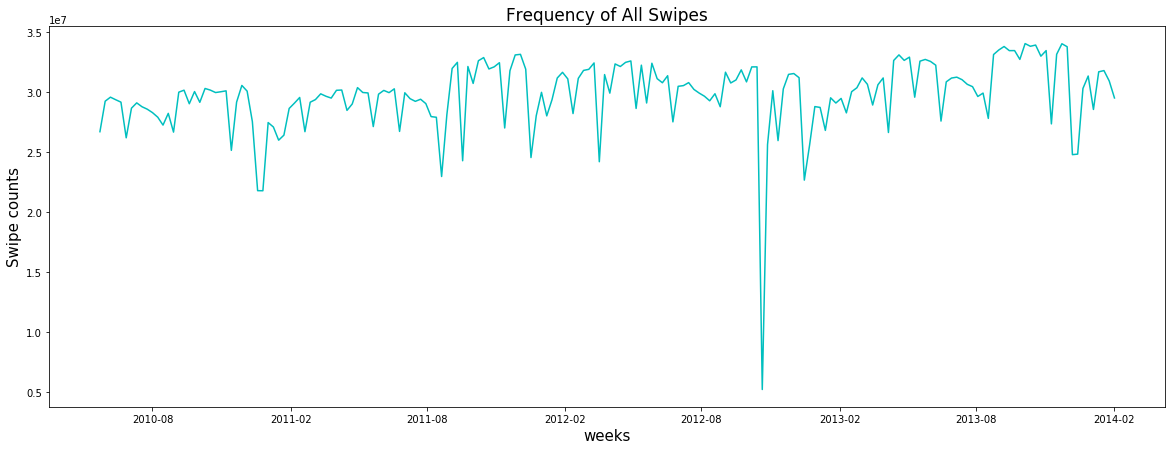

In [12]:
# plot 1
plt.figure(figsize=(20,7))
plt.plot(allswipe, c='c')
plt.title("Frequency of All Swipes", fontsize=17)
plt.xlabel("weeks", fontsize=15)
plt.ylabel("Swipe counts", fontsize=15)

**Figure 2.** Overview of the all swipe per each week. Overall between August to February 2013 there is a steep decline.

In [13]:
print ("mean swipes by week  {:.2f}".format(allswipe['Frequency'].mean()))
print ("stdev swipes by week  {:.2f}".format(allswipe['Frequency'].std()))
# thresholds = [np.nanmean(allswipe['Frequency']) + 3 * np.nanstd(allswipe['Frequency']), 
#               np.nanmean(allswipe['Frequency']) - 3 * np.nanstd(allswipe['Frequency'])]
thresholds = [np.mean(allswipe['Frequency']) + 3 * np.std(allswipe['Frequency']), 
              np.mean(allswipe['Frequency']) - 3 * np.std(allswipe['Frequency'])]
print ("3-sigma thresholds {:.2f} {:.2f}".format(*thresholds))

mean swipes by week  29781349.87
stdev swipes by week  2991680.90
3-sigma thresholds 38733231.14 20829468.61


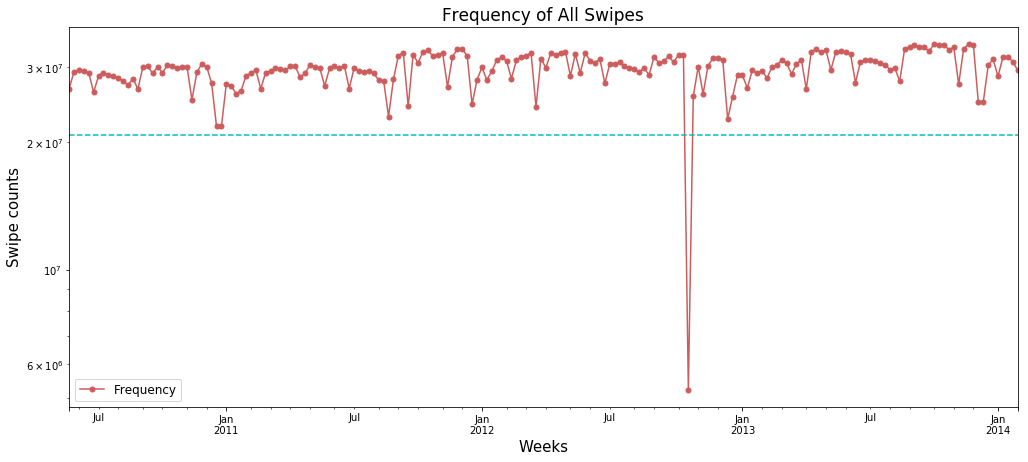

In [14]:
ax = allswipe.plot(logy=True, figsize=(17,7), style=".-", ms=10, color="IndianRed")
# set treshold
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [thresholds[1], thresholds[1]], 'c--')
plt.title("Frequency of All Swipes", fontsize=17)
plt.legend(fontsize=12, loc='lower left')
# plt.ylim(-20, plt.ylim()[1])
plt.xlabel("Weeks", fontsize=15)
plt.ylabel("Swipe counts", fontsize=15)
plt.show()

**Figure 3.** Overview of the all swipe per each week after put the thresholds of 3 sigma. The outlier is far from thresholds

In [15]:
minrider = allswipe.loc[(allswipe.Frequency < thresholds[1])]
minrider

,Frequency
2012-10-21,5218686.0


In [16]:
print ("The week with minimal ridership is {}".format(minrider.index[0]))

The week with minimal ridership is 2012-10-21 00:00:00


## Task 2: 
### Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the **ridership types**  that have steadily increased in popularity,  and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)

In [17]:
# field type
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])

In [18]:
# sum based in card
mtasumride = np.nansum(data, axis=0)
print (mtasumride.shape)

(23, 194)


In [19]:
# creating dataframe based on card
bycard = pd.DataFrame(mtasumride, index=ridetype, columns=datarange)
bycard.head(2)

,2010-05-23 00:00:00,2010-05-30 00:00:00,2010-06-06 00:00:00,2010-06-13 00:00:00,2010-06-20 00:00:00,2010-06-27 00:00:00,2010-07-04 00:00:00,2010-07-11 00:00:00,2010-07-18 00:00:00,2010-07-25 00:00:00,...,2013-12-01 00:00:00,2013-12-08 00:00:00,2013-12-15 00:00:00,2013-12-22 00:00:00,2013-12-29 00:00:00,2014-01-05 00:00:00,2014-01-12 00:00:00,2014-01-19 00:00:00,2014-01-26 00:00:00,2014-02-02 00:00:00
10t,11494615.0,12526859.0,12766627.0,12653675.0,12809694.0,11429783.0,12346877.0,12576759.0,12437115.0,12431257.0,...,14604028.0,11344945.0,11223430.0,12864865.0,12904811.0,11932970.0,13139360.0,13189610.0,12500756.0,12459947.0
14d,530524.0,583533.0,586194.0,562602.0,548858.0,455691.0,518187.0,513412.0,512192.0,522569.0,...,781529.0,596341.0,518956.0,664531.0,744990.0,613294.0,713717.0,695134.0,670228.0,679497.0


In [20]:
bycardT = bycard.T
bycardT.head(2)

,10t,14d,1d,2t,30d,7d,ada,afas,exp,ez,...,month,rfm,rr,sen,spec,tcmc,t,umlim,xbus,stud
2010-05-23,11494615.0,530524.0,47801.0,186551.0,46808.0,3697443.0,8551937.0,10063.0,333197.0,512032.0,...,123134.0,790110.0,59809.0,28221.0,0.0,124693.0,21060.0,6128.0,358.0,0.0
2010-05-30,12526859.0,583533.0,51486.0,199229.0,64353.0,3981808.0,9486394.0,11847.0,282755.0,578023.0,...,151948.0,908068.0,69209.0,32333.0,0.0,121713.0,21670.0,6120.0,474.0,0.0


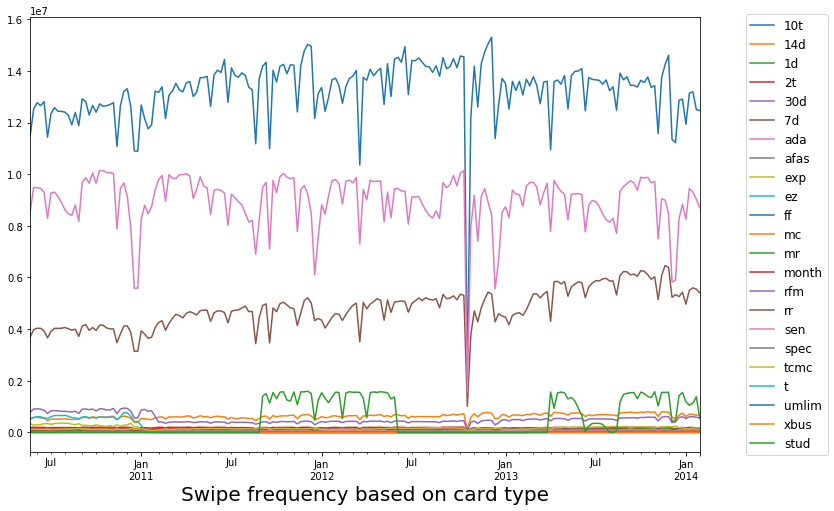

In [21]:
# plot
ax = bycardT.plot(figsize=(12,8))
ax.legend(loc='center right', bbox_to_anchor=(1.2,0.5), fontsize=12)
plt.xlabel("Swipe frequency based on card type", fontsize=20)
plt.show()

**Figure 4.** Frequencies of swipe by card type. Unlimited trip card has the most swipe.

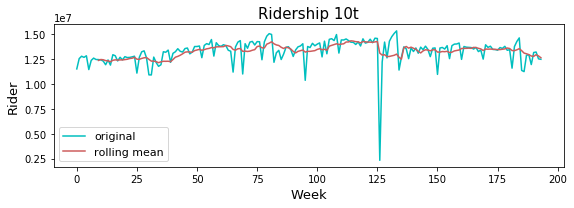

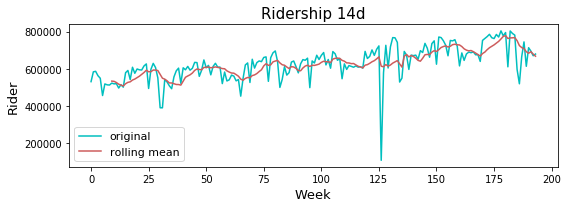

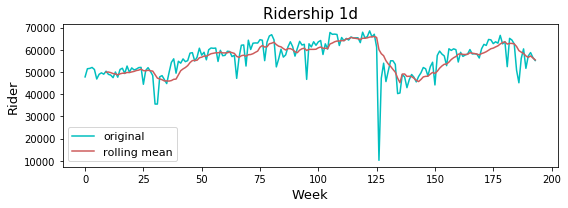

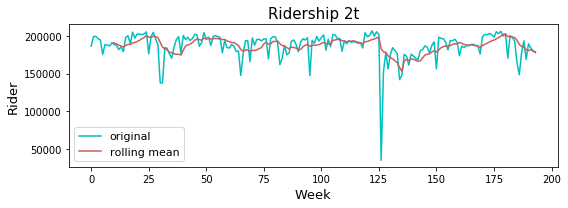

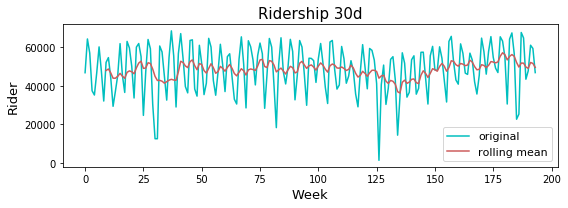

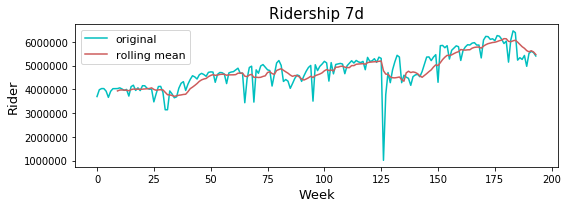

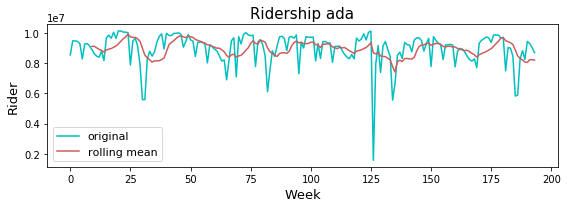

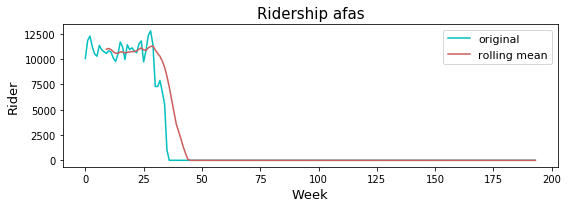

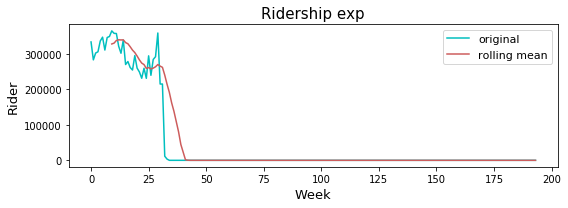

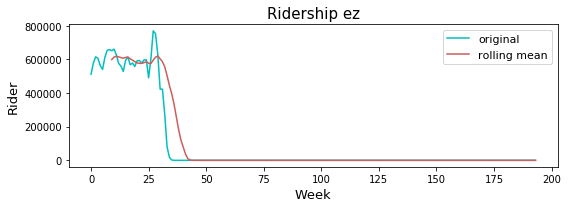

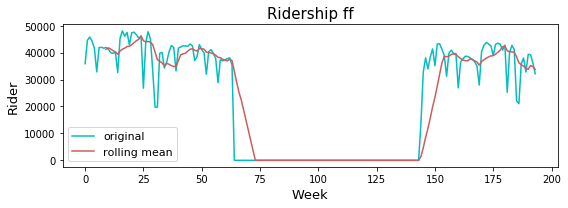

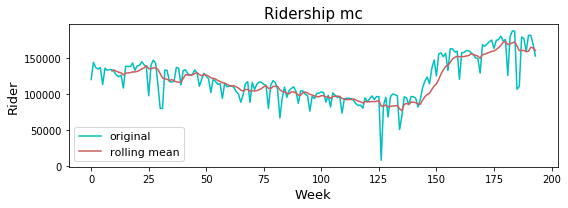

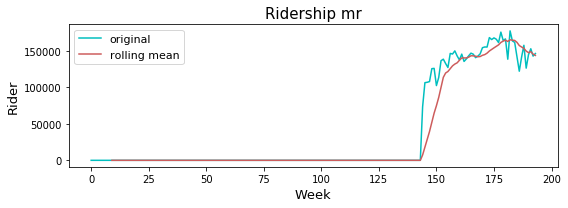

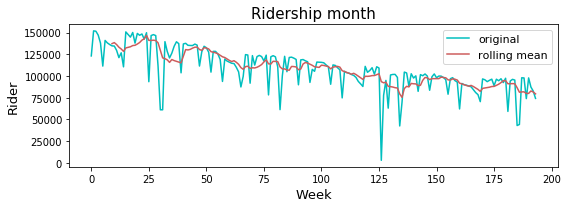

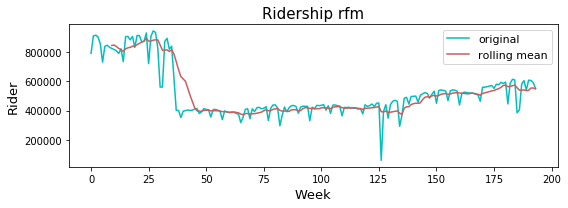

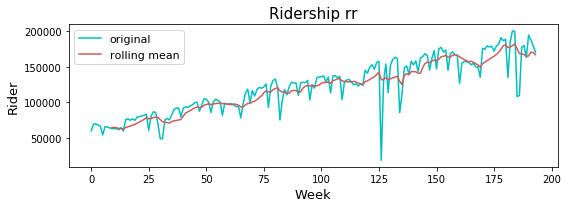

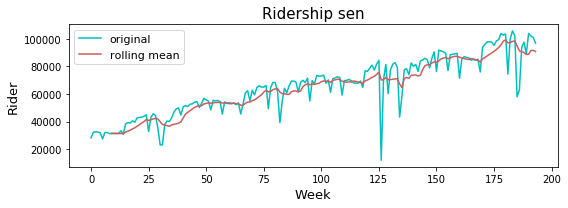

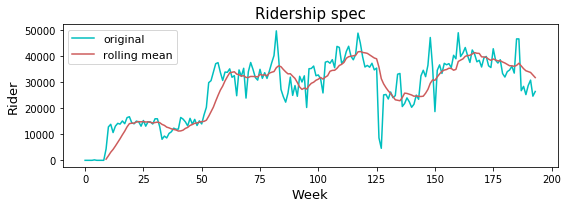

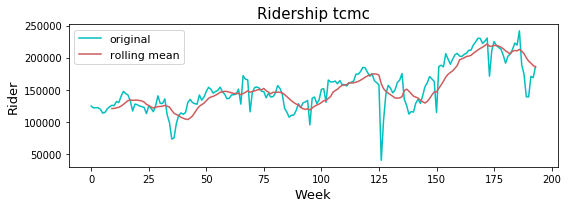

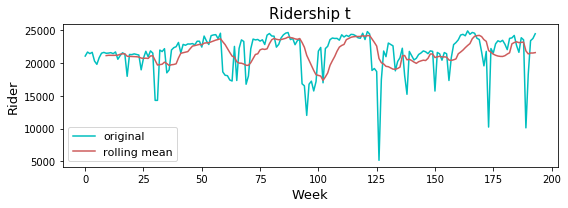

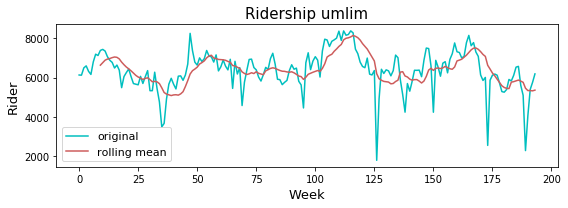

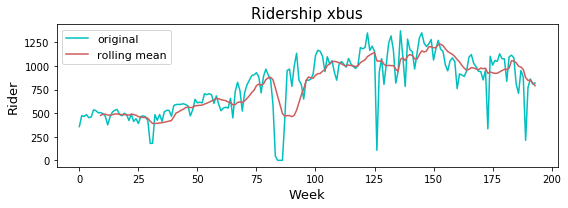

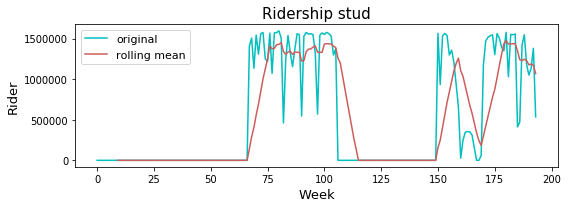

In [22]:
for i in bycardT.keys():
    plt.figure(figsize=(8,3))
    #rolling mean, window 10
    cardrmean = bycardT[i].rolling(window=10).mean()
    plt.plot(np.arange(len(bycardT[i])), bycardT[i], label="original", c='c')
    plt.plot(np.arange(len(bycardT[i])), cardrmean, label="rolling mean", c='IndianRed')
    plt.title("Ridership {}".format(i), fontsize=15)
    plt.ylabel("Rider", fontsize=13)
    plt.xlabel("Week", fontsize=13)
    plt.legend(fontsize=11)
    plt.tight_layout()
    plt.show()

**Figure 5.** Plot of all swipes and the rolling mean of each riderships. Based on the rolling mean, 7 days card, rail road card, and senior citizen/disabled card have steadily increased in popularity, while monthly card have steadily decreased

In [23]:
# calculate ratio
# I use mean for the first 10 and last 10 weeks to get the fair proportion
bycard['first 10 weeks'] = bycard.iloc[:,:11].mean(axis=1)
bycard['last 10 weeks'] = bycard.iloc[:,184:].mean(axis=1)
bycard['Difference'] = bycard['last 10 weeks'] - bycard['first 10 weeks']
bycard['Ratio'] = bycard['last 10 weeks'] / bycard['first 10 weeks']
ratio = bycard[['first 10 weeks','last 10 weeks','Difference','Ratio']].copy()

In [24]:
ratio

,first 10 weeks,last 10 weeks,Difference,Ratio
10t,1.235226e+07,1.259245e+07,2.401951e+05,1.019445e+00
14d,5.320349e+05,6.554774e+05,1.234425e+05,1.232020e+00
1d,4.981336e+04,5.494203e+04,5.128669e+03,1.102958e+00
2t,1.904650e+05,1.791410e+05,-1.132400e+04,9.405455e-01
30d,4.856564e+04,4.948460e+04,9.189669e+02,1.018922e+00
7d,3.946064e+06,5.329359e+06,1.383296e+06,1.350551e+00
ada,9.072432e+06,8.283282e+06,-7.891498e+05,9.130167e-01
afas,1.096718e+04,9.991074e+02,-9.968074e+03,9.109974e-02
exp,3.302195e+05,3.002313e+04,-3.001963e+05,9.091873e-02
ez,6.048605e+05,5.498814e+04,-5.498724e+05,9.091044e-02


## Task 3:
### Several stations show a prominent annual periodicity. Identify the 4 **stations** (indentify them by the index of their location in the data cube) that show the most prominent periodic trend on an annual period (52 weeks). (Can you figure out what the periodic peak in rides is due to?)

In [25]:
# compare by station
mtasumstation = pd.DataFrame(mtasumstation.T,index=datarange)

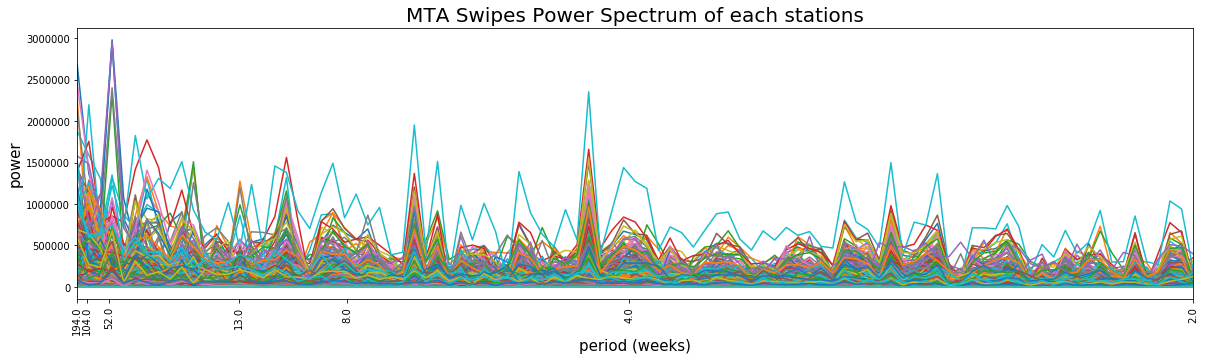

In [26]:
# fourier transform plot
fig=plt.figure(figsize=(20, 5))
periods = [1./194, 1./104, 1./52, 1./13, 1./8, 0.25, 0.5]
ax = fig.add_subplot(111)
fft = pd.DataFrame()
for i in range(600):
    f = np.abs(np.fft.rfft(mtasumstation[i]))
    ax.plot(np.fft.rfftfreq(194, 1.0)[1:], (f[1:]), '-')
    fft = pd.concat([fft,pd.DataFrame(f)],axis=1)
fft.columns = range(600)
ax.set_xlim([1/194.0, 1/2.0])
ax.set_xticks(periods)
ax.set_xticklabels(["%s" %(1/f) for f in ax.get_xticks()], rotation=90, fontsize=10)
plt.xlabel("period (weeks)", fontsize=15)
plt.ylabel("power", fontsize=15)
plt.title("MTA Swipes Power Spectrum of each stations", fontsize=20)
plt.show()

**Figure 7.** Power spectrum from fourier transform plot for 600 stations. With all of the 600, it's difficult to see the most prominent stations.

In [27]:
# check which index has the most power
fft.iloc[1:,:].apply(max, axis=1).sort_values(ascending=False).head(1)

4    2.980161e+06
dtype: float64

In [28]:
# check which top 4 prominent station
fft.ix[4].sort_values(ascending=False).head(4)

0      2.980161e+06
194    2.950389e+06
150    2.931896e+06
327    2.402219e+06
Name: 4, dtype: float64

Text(0.5,1,'Weekly MTA Subway Ridership for top 4 Stations with Annual Periodicity')

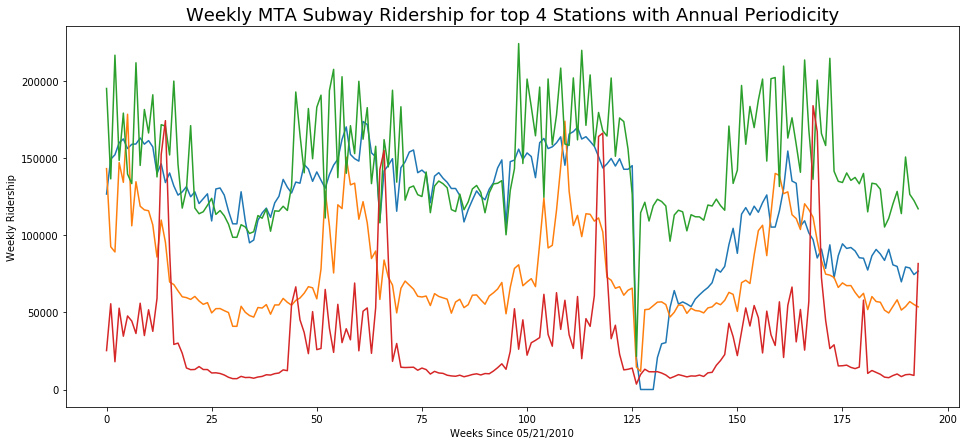

In [29]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,7))
for x in [0,150,194,327]:
    ax.plot(range(194), mtasumstation[x])
plt.xlabel('Weeks Since 05/21/2010')
plt.ylabel('Weekly Ridership')
plt.title('Weekly MTA Subway Ridership for top 4 Stations with Annual Periodicity', fontsize=18)

**Figure 8.** Top 4 prominent stations. Each station has similar trend.

## EXTRA CREDIT: Cluster. 
### Cluster the time series, i.e. identify groups of time series that look similar among each other. You can use KMeans for example to identify common trends, or PCA (Principle Component Analysis). 
### Since this is extra credit I will leave it to you to figure out the details, but for KMeans for e.g. if you use the sklearn.cluster package it would look something like:

i am flattening the first 2 dimensions of the cube to cluster all light curves for all stations and all types

```
tots = data.transpose(2,0,1).reshape(data.shape[2], data.shape[1]*data.shape[0]).T
```

removing empty light curves

```
tots = tots[tots.std(1)>0]
```

with Kmeans you have to choose the number of clusters ahead km = 

```
KMeans(n_clusters=10)
```

and standardize the lightcurves before clustering. Notice: standardize, not whiten! If you have done clustering before you may have whitened the data: removed the variance by "column", here you want to remove the variance by "row". We will discuss this in the clustering lecture. 
```
vals = ((tots.T - tots.mean(1))/tots.std(1)).T
```

then you can run:

```
km.fit(vals)
```

*  after you operate on the array to collapse an axis, always check the dimensionality to assure you have indeed collapsed the right axis! see cell below

```
import numpy as np
data = np.random.rand(100,10)

print(data.shape)
Out[12]: (100, 10)

print(data.mean())
Out[13]:  0.4902457782

print(data.mean(axis=0).shape, data.mean(axis=1).shape)
Out[14]: (10,) (100,)

```

In [30]:
tots = data.transpose(2,0,1).reshape(data.shape[2], data.shape[1]*data.shape[0]).T
tots.shape

(13800, 194)

In [31]:
tots = tots[tots.std(1)>0]
vals = ((tots.T - tots.mean(1))/tots.std(1)).T
vals.shape

(7660, 194)

In [32]:
# I'm using elbow method fist
# this function is from ADS Lab 8
def elbow(data,K): 
    KM = [KMeans(n_clusters=k).fit(data) for k in K]
    centroids = [k.cluster_centers_ for k in KM]
    D_k = [cdist(data, cent, 'euclidean') for cent in centroids]    
    globals()['dist'] = [np.min(D,axis=1) for D in D_k]    
    avgWithinSS = [sum(d)/data.shape[0] for d in dist]
    
    # elbow curve
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, avgWithinSS, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average within-cluster sum of squares')
    plt.title('Elbow for KMeans clustering')
    plt.show()
    
    # Total with-in sum of square plot. Another way to show the result.
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(data)**2)/data.shape[0]
    bss = tss-wcss
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, bss/tss*100, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Percentage of variance explained')
    plt.title('Elbow for KMeans clustering')
    plt.show()

In [ ]:
elbow(vals, range(1,30))

KeyboardInterrupt: 

**Figure 9.** Elbow method result for clustering. Seems like the cluster is inconclusive.

In [ ]:
# crosscheck with silhoutte method
n = 3
pca = PCA(n)
Xproj = pca.fit_transform(vals)
range_n_clusters = np.arange(2,15)
for n_clusters in range_n_clusters:
    km = KMeans(n_clusters=n_clusters, random_state=324)
    cluster_labels = km.fit_predict(Xproj)
    silhouette_avg = silhouette_score(Xproj, cluster_labels)
    print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))

In [ ]:
# from the silhouette score, the highest one is n cluster = 7
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.scatter(Xproj[:, 0], Xproj[:, 1], c=cluster_labels.labels_, cmap=plt.cm.inferno, alpha=0.4)
ax.set_xlabel('First principal component', fontsize=15)
ax.set_ylabel('Second principal component', fontsize=15)
ax.set_title('MTA Subway swipe cluster', fontsize=20)

**Figure 10.** MTA swipe with 7 clusters

Grade: 10/10